## Transfer learning using MobileNetV3

Training neural networks on images is time-consuming if starting from a scratch. Transfer learning is a powerful technique as it lets use the networks and the trained parameters of previous models. With slight modification you can take advantage of other models for your purpose with minimum efforts.

This Notebook will show how to do that. We will be using MobileNetV3 model that provides good classification performance with reasonable calculation requirements for inference. We will be using the pretrained model parameters, but our task has only have 10 objects to classify using the Fashion-MNIST dataset, where MobileNetV3 can classify 1000 items. To be able to use MobileNetV3 for our task, We only need to modify the final layer and train its parameters without updating the other parameters. This will make our training process much faster.

In [1]:
# Import crucial pytorch packages
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
print("Pytorch Version: ", torch.__version__)
!nvcc --version

Pytorch Version:  2.5.1
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Feb_27_16:28:36_Pacific_Standard_Time_2024
Cuda compilation tools, release 12.4, V12.4.99
Build cuda_12.4.r12.4/compiler.33961263_0


In [2]:
# Load the Fashion-MNIST dataset which is available in the Pytorch torchvision package.
def load_data(batch_size, data_dir="data"):
    # Normalize the input data 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]) 

    # Download the dataset and create trainloader and testloader
    trainset = datasets.FashionMNIST(data_dir, download=True, train=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = datasets.FashionMNIST(data_dir, download=True, train=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

    return trainloader, testloader


In [3]:
# Load the dataset using load_data method. We will use the batch size of 64.
trainloader, testloader = load_data(64)

In [4]:

# Return the list of classes in the Fashion-MNIST dataset.
def get_class_names():
    return [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]

# Return the class name for the given index.
def get_class_name(class_index):
    return get_class_names()[class_index]

# Return the class index for the given name.
def get_class_index(class_name):
    return get_class_names().index(class_name)


In [5]:
# Test above methods
for class_index in range(10):
    print(f"class_index={class_index}, class_name={get_class_name(class_index)}")

for class_label in get_class_names():
    print(f"class_label={class_label}, class_index={get_class_index(class_label)}")

class_index=0, class_name=T-shirt/top
class_index=1, class_name=Trouser
class_index=2, class_name=Pullover
class_index=3, class_name=Dress
class_index=4, class_name=Coat
class_index=5, class_name=Sandal
class_index=6, class_name=Shirt
class_index=7, class_name=Sneaker
class_index=8, class_name=Bag
class_index=9, class_name=Ankle boot
class_label=T-shirt/top, class_index=0
class_label=Trouser, class_index=1
class_label=Pullover, class_index=2
class_label=Dress, class_index=3
class_label=Coat, class_index=4
class_label=Sandal, class_index=5
class_label=Shirt, class_index=6
class_label=Sneaker, class_index=7
class_label=Bag, class_index=8
class_label=Ankle boot, class_index=9


Shape of image = torch.Size([64, 1, 28, 28]), Shape of labels = torch.Size([64])


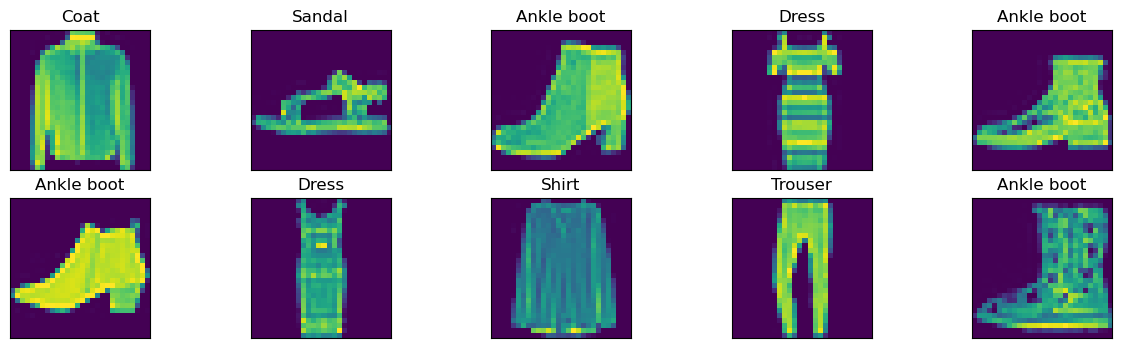

In [6]:
# Show 10 images in the Fashion-MNIST dataset
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# Obtain the first batch just to visualize
images, labels = next(iter(trainloader))
print(f"Shape of image = {images.shape}, Shape of labels = {labels.shape}")

fig = plt.figure(figsize=(15,4))
plot_size = 10

for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(get_class_name(int(labels[idx])))

In [7]:
# Create a MobileNetV3 model instance
import torchvision.models as models
mobilenet_v3_model = models.mobilenet_v3_small(predtrained=True)
print(mobilenet_v3_model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [8]:
# Look at the final layer of the original MobileNetV3 that would classify 1000 objects. 
# We need to replace this layer with a fully connected network that would classify only 10 objects.
print(mobilenet_v3_model.classifier)

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)


In [9]:
import torch.nn.functional as F
from torch import nn

class ModifiedMobileNetV3(nn.Module):
    # Initialize model structure
    def __init__(self):
        super(ModifiedMobileNetV3, self).__init__()
        self.model = models.mobilenet_v3_small(pretrained=True)

        # Replace the final layer to 1024x10 fully connected layer
        self.model.classifier[3] = nn.Linear(1024, 10)
        self.freeze()
        
    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        # Format the input image to 224x224 as this is the image size that MobileNetV3 would use
        if x.shape[2:] != (224, 224):
            x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
        return self.model(x)

    def freeze(self):
        # Block parameter updates on all layers
        for param in self.model.parameters():
            param.requires_grad = False
        # Unblock parameter updates only for the final layer
        for param in self.model.classifier[3].parameters():
            param.requires_grad = True

    # Allow model parameter updates on ALL layers
    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True


In [10]:
# Create a modified model instance
model = ModifiedMobileNetV3()
print(model)

ModifiedMobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2)

C:\Users\jkang\.conda\envs\udacity\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jkang\.conda\envs\udacity\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Define the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.002)

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Set the CUDA device for the model
model = model.to(device)

Using device: cuda


In [13]:
model = model.to(device)
epochs = 50
for epoch in range(epochs):
    for batch_num, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        # Start gradient calculation fresh. We don't want any accumulation from previous gradient calculations.
        optimizer.zero_grad()

        # Calculate a forward pass for all layer on 1 batch (= 64 images)
        outputs = model(images)

        # Calculate loss
        loss = loss_func(outputs, labels)

        # Back-propagation
        loss.backward()

        # Update the weights on the final layer
        optimizer.step()
        
        if (batch_num) % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Batch [{batch_num}/{len(trainloader)}], Loss:{loss.item():.5f}" )    

Epoch [0/50], Batch [0/938], Loss:2.32989
Epoch [0/50], Batch [100/938], Loss:1.88842
Epoch [0/50], Batch [200/938], Loss:1.55098
Epoch [0/50], Batch [300/938], Loss:1.35767
Epoch [0/50], Batch [400/938], Loss:1.29191
Epoch [0/50], Batch [500/938], Loss:1.20502
Epoch [0/50], Batch [600/938], Loss:1.04438
Epoch [0/50], Batch [700/938], Loss:0.92111
Epoch [0/50], Batch [800/938], Loss:1.01610
Epoch [0/50], Batch [900/938], Loss:0.88573
Epoch [1/50], Batch [0/938], Loss:0.96205
Epoch [1/50], Batch [100/938], Loss:0.91589
Epoch [1/50], Batch [200/938], Loss:0.77741
Epoch [1/50], Batch [300/938], Loss:0.83112
Epoch [1/50], Batch [400/938], Loss:0.83759
Epoch [1/50], Batch [500/938], Loss:0.68382
Epoch [1/50], Batch [600/938], Loss:0.69465
Epoch [1/50], Batch [700/938], Loss:0.71767
Epoch [1/50], Batch [800/938], Loss:0.73554
Epoch [1/50], Batch [900/938], Loss:0.76865
Epoch [2/50], Batch [0/938], Loss:0.72091
Epoch [2/50], Batch [100/938], Loss:0.69431
Epoch [2/50], Batch [200/938], Loss:0.

In [14]:
correct_predict_count = 0
total_predict_count = 0
loss = 0

for images, labels in testloader:
    # Set up proper device on the test data tensors
    images_test = images.to(device)
    labels_test = labels.to(device)

    # Calculate output for prediction on the test data
    outputs_test = model(images_test)
    loss += loss_func(outputs_test, labels_test)

    _, predicted = torch.max(outputs_test.data, dim=1)

    total_predict_count += labels.size(0)
    correct_predict_count += (predicted == labels_test).sum()

print(f"Prediction accuracy on the test data set : {100*correct_predict_count/total_predict_count:.2f}%")

    

Prediction accuracy on the test data set : 85.53%


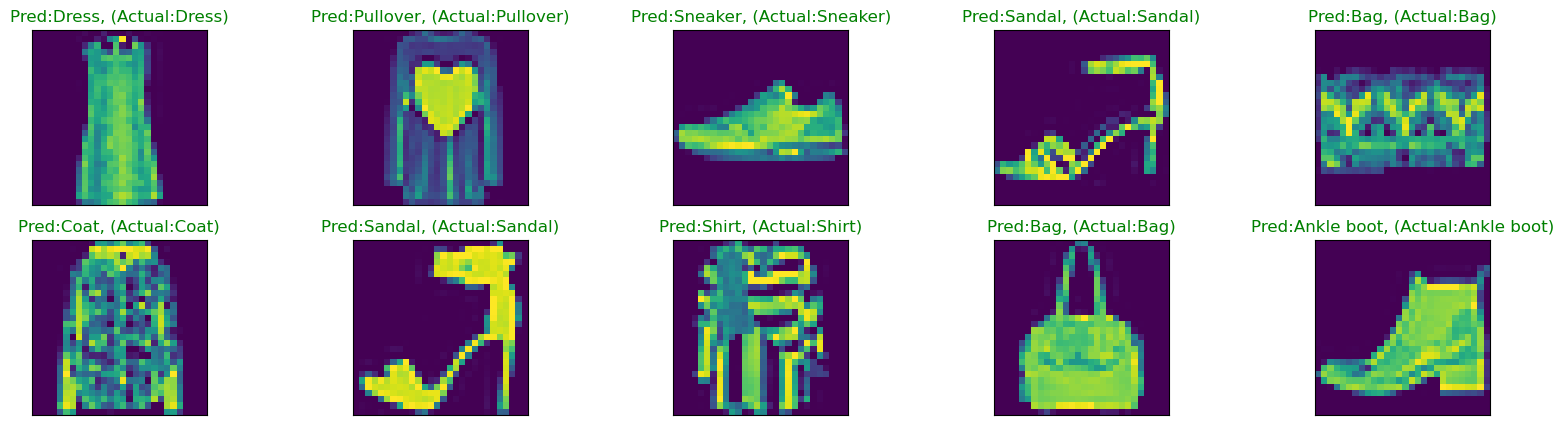

In [15]:

# Plot a few images and the prediction results from the final batch in the test loader
fig =plt.figure(figsize=(20,5))
for i in np.arange(min(10, len(images_test))):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images_test.cpu()[i]))
    ax.set_title(f"Pred:{get_class_name(predicted[i])}, (Actual:{get_class_name(labels_test[i])})", 
                 color=("green" if predicted[i] == labels[i] else "red"))

### Without Training the full network, we could achieve over 85% classification performance by adapting previously trainined model for our classification task.